# Initialisation

In [61]:
import os
import torch
os.environ['TORCH'] = torch.__version__
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv
from torch_geometric.transforms import NormalizeFeatures

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

Dataframe_Labels = pd.read_csv("../../../BLCA_DATA/Workspace/labels_str.csv")
Dataframe_link = pd.read_csv("../../../BLCA_DATA/Workspace/patient_norm.csv")
Dataframe_node= pd.read_csv("../../../BLCA_DATA/Workspace/node_embedding.csv")

Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])
Dataframe_Labels

,Patient,class,class_int
0,TCGA-2F-A9KO,LumP,0
1,TCGA-2F-A9KP,LumP,0
2,TCGA-2F-A9KQ,LumP,0
3,TCGA-2F-A9KR,Ba/Sq,1
4,TCGA-2F-A9KT,Ba/Sq,1
...,...,...,...
399,TCGA-ZF-AA56,Ba/Sq,1
400,TCGA-ZF-AA58,Ba/Sq,1
401,TCGA-ZF-AA5H,Ba/Sq,1
402,TCGA-ZF-AA5N,LumP,0


# Mise en place des arretes, noeuds et leur poids

### à améliorer, modification du treshold

In [62]:
node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

x = node_features
patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])
similarity_threshold = 0.5  # Exemple de seuil de similarité

edge_index = []
edge_attr = []

for i in range(patient_similarity.shape[0]):
    for j in range(i + 1, patient_similarity.shape[0]):
        if patient_similarity[i, j] > similarity_threshold:
            edge_index.append([i, j])
            edge_attr.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
        patient_similarity[i, i] = 0

edge_index = torch.tensor(edge_index, dtype=torch.int64).t().contiguous()
edge_features = torch.tensor(Dataframe_link.drop(columns=['Patient']).values, dtype=torch.float)
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

temporary_node_tab = Dataframe_Labels["class_int"].values
node_labels = torch.tensor(temporary_node_tab, dtype=torch.long)
print(node_labels)
print(edge_index, len(edge_index))
print(edge_features, len(edge_features))
print(edge_attr, len(edge_attr))

tensor([0, 0, 0, 1, 1, 2, 2, 3, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 2, 4,
        1, 1, 5, 1, 1, 1, 1, 1, 1, 0, 3, 3, 0, 1, 1, 2, 1, 5, 4, 1, 0, 1, 1, 0,
        1, 1, 5, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 1, 2, 1, 2, 0, 0, 1, 2, 4, 1, 3, 0,
        3, 4, 1, 1, 1, 4, 2, 1, 1, 3, 0, 4, 1, 2, 1, 1, 3, 0, 1, 0, 0, 2, 4, 1,
        0, 1, 1, 0, 1, 1, 1, 3, 2, 5, 0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0,
        0, 0, 0, 0, 0, 3, 2, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 2, 3, 3, 1, 1, 1, 3, 2, 1, 2, 2, 3, 3, 0, 1, 0, 3, 1, 1, 0, 3, 1, 3,
        3, 1, 1, 0, 1, 1, 4, 3, 3, 1, 0, 3, 3, 1, 4, 1, 2, 0, 2, 3, 0, 1, 0, 1,
        1, 0, 5, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 1, 3, 0, 1, 0, 1, 1, 2, 1, 2, 4,
        4, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 3, 2, 1, 4, 0, 2, 2, 0, 3, 2, 0,
        0, 1, 2, 0, 2, 0, 0, 2, 1, 1, 3, 4, 1, 1, 1, 0, 1, 1, 1, 1, 2, 3, 3, 0,
        0, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1,

In [63]:
classes_dict = {0: 'LumP', 
                1: 'Ba/Sq', 
                2: 'LumU', 
                3: 'Stroma-rich', 
                4: 'LumNS', 
                5: 'NE-like'
}

def count_classes_weights(tensor):
    array = tensor.numpy()
    N = np.shape(array)[0]
    classes_tab = { 0: 0, 
                    1: 0,
                    2: 0, 
                    3: 0, 
                    4: 0,
                    5: 0
    }
    for i in array:
        classes_tab[i]+=1

    mean_nb_classes = 0
    for i in classes_tab:
        mean_nb_classes += i
    mean_nb_classes *= 1/len(classes_tab)
    
    # normalize the weights
    weight_sum = 0
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_sum += mean_nb_classes / classes_tab[i]
    alpha = 1 / weight_sum

    weight_dict = {}
    used_classes = []
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_dict[i] = alpha * (mean_nb_classes / classes_tab[i]) *50
            used_classes.append(classes_dict[i])

    return used_classes, weight_dict

used_classes, weight_dict = count_classes_weights(node_labels)

Dataframe_Labels['weight'] = [weight_dict[x] for x in Dataframe_Labels['class_int']]

node_weights = torch.tensor(Dataframe_Labels['weight'], dtype=torch.float)
node_weights


tensor([ 1.4465,  1.4465,  1.4465,  1.2007,  1.2007,  3.4662,  3.4662,  4.0825,
         1.4465,  1.2007,  3.4662,  1.4465,  1.2007,  1.4465,  3.4662,  1.2007,
         1.2007,  1.4465,  1.2007,  1.2007,  3.4662,  1.4465,  3.4662,  9.1855,
         1.2007,  1.2007, 30.6185,  1.2007,  1.2007,  1.2007,  1.2007,  1.2007,
         1.2007,  1.4465,  4.0825,  4.0825,  1.4465,  1.2007,  1.2007,  3.4662,
         1.2007, 30.6185,  9.1855,  1.2007,  1.4465,  1.2007,  1.2007,  1.4465,
         1.2007,  1.2007, 30.6185,  1.2007,  1.2007,  1.4465,  1.2007,  1.4465,
         1.2007,  1.4465,  1.4465,  1.4465,  1.4465,  1.4465,  1.4465,  1.4465,
         1.4465,  1.4465,  1.4465,  1.4465,  1.4465,  1.4465,  1.4465,  1.4465,
         1.4465,  1.4465,  1.4465,  1.4465,  1.4465,  1.2007,  1.4465,  3.4662,
         1.2007,  3.4662,  1.4465,  1.4465,  1.2007,  3.4662,  1.2007,  3.4662,
         1.4465,  1.4465,  1.2007,  3.4662,  9.1855,  1.2007,  4.0825,  1.4465,
         4.0825,  9.1855,  1.2007,  1.20

# 1er GATv2 - Simple

### Définition des masques utilisés

In [64]:
def set_mask(start, length=0, to_end=False):
    mask = []
    for i in range(404):
        if (i < start or i >= start + length) and not to_end: 
            mask.append(False)
        else : 
            mask.append(True)
    return mask

In [65]:
# data on which the model will be trained
train_length = int(404 * 0.7)
train_mask = torch.tensor(set_mask(start=0, length=train_length), dtype=torch.bool)

length = int((404 - train_length) * 0.5)
val_mask = torch.tensor(set_mask(start=train_length, length=length), dtype=torch.bool)

test_mask = torch.tensor(set_mask(start=train_length + length, length=length), dtype=torch.bool)

train_mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

### Définition de l'objet data utilisé

In [66]:
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=node_labels, weights = node_weights, num_classes=6, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

In [67]:
class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x
    

model = GATv2(hidden_channels=16, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    print("test", len(mask))
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    #print(f"out shape: {out.shape}")
    pred = out.argmax(dim=1)
    #print(pred[mask])
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc , pred

for epoch in range(1, 2):
    loss = train()
    val_acc = test(data.val_mask)[0]
    test_acc, pred = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val {val_acc:.4f}, Test {test_acc:.4f}')

GATv2(
  (conv1): GATv2Conv(825, 16, heads=8)
  (conv2): GATv2Conv(128, 6, heads=1)
)
test 404
test 404
Epoch: 001, Loss: 2.0898, Val 0.2623, Test 0.2951


In [68]:
print(data.y[data.test_mask])
print(pred[test_mask])

tensor([1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 0, 3, 1, 1, 2, 4, 0, 1, 0, 1, 1, 1, 1, 5,
        3, 0, 0, 1, 0, 1, 4, 0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 1, 0, 0, 1, 1, 1, 2,
        0, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 3])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# 2eme GATv2 - Avec mise à jour des poids des classes

In [69]:
from sklearn.model_selection import train_test_split

train_val_indices, test_indices = train_test_split(
    range(data.x.shape[0]), 
    test_size=0.2, 
    stratify=data.y, 
    random_state=42
)

node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

x_train = node_features[train_val_indices]
x_test = node_features[test_indices]

patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])
similarity_threshold = 0.5  # Exemple de seuil de similarité

# Calculate the edges and attention ridges for training
edge_index_for_training = []
edge_attr_for_training = []

for i in train_val_indices:
    for j in train_val_indices:
        if i >= j :
            break
        if patient_similarity[i, j] > similarity_threshold:
            edge_index_for_training.append([i, j])
            edge_attr_for_training.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))

# Calculate the edges and attention ridges for testing
edge_index_for_testing = []
edge_attr_for_testing = []
for i in test_indices:
    for j in test_indices:
        if i >= j :
            break
        if patient_similarity[i, j] > similarity_threshold:
            edge_index_for_testing.append([i, j])
            edge_attr_for_testing.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))


In [70]:
edge_features_for_training = torch.tensor(x_train, dtype=torch.float)
edge_index_for_training = torch.tensor(edge_index_for_training, dtype=torch.int64).t().contiguous()
edge_attr_for_training = torch.tensor(edge_attr_for_training, dtype=torch.float)
node_weights_for_training = node_weights[train_val_indices]

edge_features_for_testing = torch.tensor(x_test, dtype=torch.float)
edge_index_for_testing = torch.tensor(edge_index_for_testing, dtype=torch.int64).t().contiguous()
edge_attr_for_testing = torch.tensor(edge_attr_for_testing, dtype=torch.float)
node_weights_for_testing = node_weights[test_indices]

node_labels = Dataframe_Labels["class_int"].values
train_labels = torch.tensor(node_labels[train_val_indices], dtype=torch.long)
test_labels = torch.tensor(node_labels[test_indices], dtype=torch.long)

/tmp/ipykernel_10580/743607179.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features_for_training = torch.tensor(x_train, dtype=torch.float)
/tmp/ipykernel_10580/743607179.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features_for_testing = torch.tensor(x_test, dtype=torch.float)


In [71]:
num_classes = 6

train_val_data = Data(
    x=edge_features_for_training, 
    edge_index=edge_index_for_training, 
    edge_attr=edge_attr_for_training, 
    y=train_labels, 
    weights=node_weights_for_training, 
    num_classes=num_classes,
    num_nodes = len(edge_features_for_training)
)

test_data = Data(
    x=edge_features_for_testing, 
    edge_index=edge_index_for_testing, 
    edge_attr=edge_attr_for_testing, 
    y=test_labels, 
    weights=node_weights_for_testing, 
    num_classes=num_classes, 
    num_nodes = len(edge_features_for_testing)
)

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sn
import random

class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x

def weighted_cross_entropy_loss(output, target, weights):
    loss = F.cross_entropy(output, target, reduction='none')
    weighted_loss = loss * weights[target]
    return weighted_loss.mean()

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = weighted_cross_entropy_loss(out[data.train_mask], data.y[data.train_mask], data.weights[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, model


def test(model, data, mask, num_classes):
    data.num_classes = num_classes
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask]

def cross_validation(data, k_folds, hidden_channels, heads, num_epochs=1000):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1234)
    all_val_acc = []

    val_acc_best = 0

    for fold, (train_index, val_index) in enumerate(skf.split(data.x, data.y)):
        # Define masks
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[train_index] = True
        
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask[val_index] = True
        
        train_classes, _ = count_classes_weights(data.y[data.train_mask])
        val_classes, _ = count_classes_weights(data.y[data.val_mask])

        num_classes_for_train = len(train_classes)
        num_classes_for_val = len(val_classes)

        print(val_classes, len(val_classes))

        # Initialize model, optimizer, and loss function
        model = GATv2(hidden_channels=hidden_channels, heads=heads)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        lost_function_compil = []
        all_val_acc_plot = []

        # Training loop
        for epoch in range(1, num_epochs):
            loss, model = train(model, data, optimizer)
            train_acc, _ = test (model, data, data.train_mask, num_classes_for_train)
            val_acc, _ = test(model, data, data.val_mask, num_classes_for_val)
            lost_function_compil.append(loss.detach().tolist())
            all_val_acc_plot.append(val_acc)

            print(f'Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train_acc {train_acc:.4f}, Val_acc {val_acc:.4f}')

        # Evaluate on validation set
        val_acc, y_pred = test(model, data, data.val_mask, num_classes_for_val)
        y_true = data.y[data.val_mask]

        # Store results
        all_val_acc.append(val_acc)
        conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

        if val_acc > val_acc_best:
            best_model = model

        # Plot confusion matrix
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(conf_matrix_normalized, index=val_classes, columns=val_classes)  
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix on Validation')
        plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Function over Epochs')
        ax1.legend()

        ax2.plot(range(len(all_val_acc_plot)), all_val_acc_plot, label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('val_accuracy')
        ax2.set_title('val_accuracy over Epochs')
        ax2.legend()

        plt.show()

    # Calculate and print overall metrics
    mean_val_acc = np.mean(all_val_acc)
    std_val_acc = np.std(all_val_acc)
    print(f'Mean Validation Accuracy: {mean_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}')

    return best_model
    
best_model = cross_validation(train_val_data, k_folds=10, hidden_channels=20, heads=8, num_epochs=1)

"""labels=['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(train_classes, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
ax1.set_title('Cancer repartition for training', fontsize=14)

ax2.pie(val_classes, labels=labels, startangle=90, autopct='%1.1f%%')
ax2.axis('equal')
ax2.set_title('Cancer repartition for validation', fontsize=14)

plt.show()"""

['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like'] 6


/home/remik/Documents/Cassiopée/cassiopee-projet/Cass/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


RuntimeError: index 333 is out of bounds for dimension 0 with size 323

In [ ]:
print(data.train_mask)
print(data.val_mask)
print(data.test_mask)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

Test accuracy: 0.9508


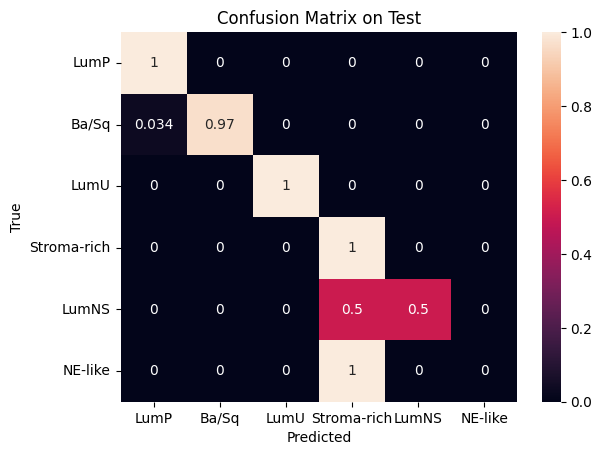

In [ ]:
test_acc, y_pred = test(best_model, data, data.test_mask)
y_true = data.y[data.test_mask]

conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

print(f'Test accuracy: {test_acc:.4f}')

classes = ('LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like')
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_matrix_normalized, index=classes, columns=classes)  
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test')
plt.show()